In [218]:
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle

# conversion from l coordinate to lonlat coordinate
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = a - ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

#---------------------------------------------------------------------------------------------------------------
# 流域IDと色の紐付け
#---------------------------------------------------------------------------------------------------------------

def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    return result

def is_whiteish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return (r + g + b) / 3 > 230  # Check if the average is above the threshold

def is_grayish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    deviation = max(r, g, b) - min(r, g, b)
    return deviation <= 20

def is_blueish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return  b - r > 120 and b - g > 120  # If blue is dominant and significantly larger

def get_filtered_colors(all_colors):
    result = []
    for color in all_colors:
        if color != '#00FFFF' and not is_whiteish(color) and not is_grayish(color) and not is_blueish(color):
            result.append(color)
    return result

def make_cmap(Rivnum_masked_array):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)

    # 流域に固有の色を割り振る
    all_colors = list(CSS4_COLORS.values())
    filtered_colors = get_filtered_colors(all_colors)
    colors_list = filtered_colors[:num_colors]

    # -1<=x<0に透明色を追加
    colors_list.insert(0, '#00000000')

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

0
Tokyo
wide_lat 1365
wide_lat 1653
wide_lon 3693
wide_lon 3981 

lat 1497
lat 1521
lon 3825
lon 3849 



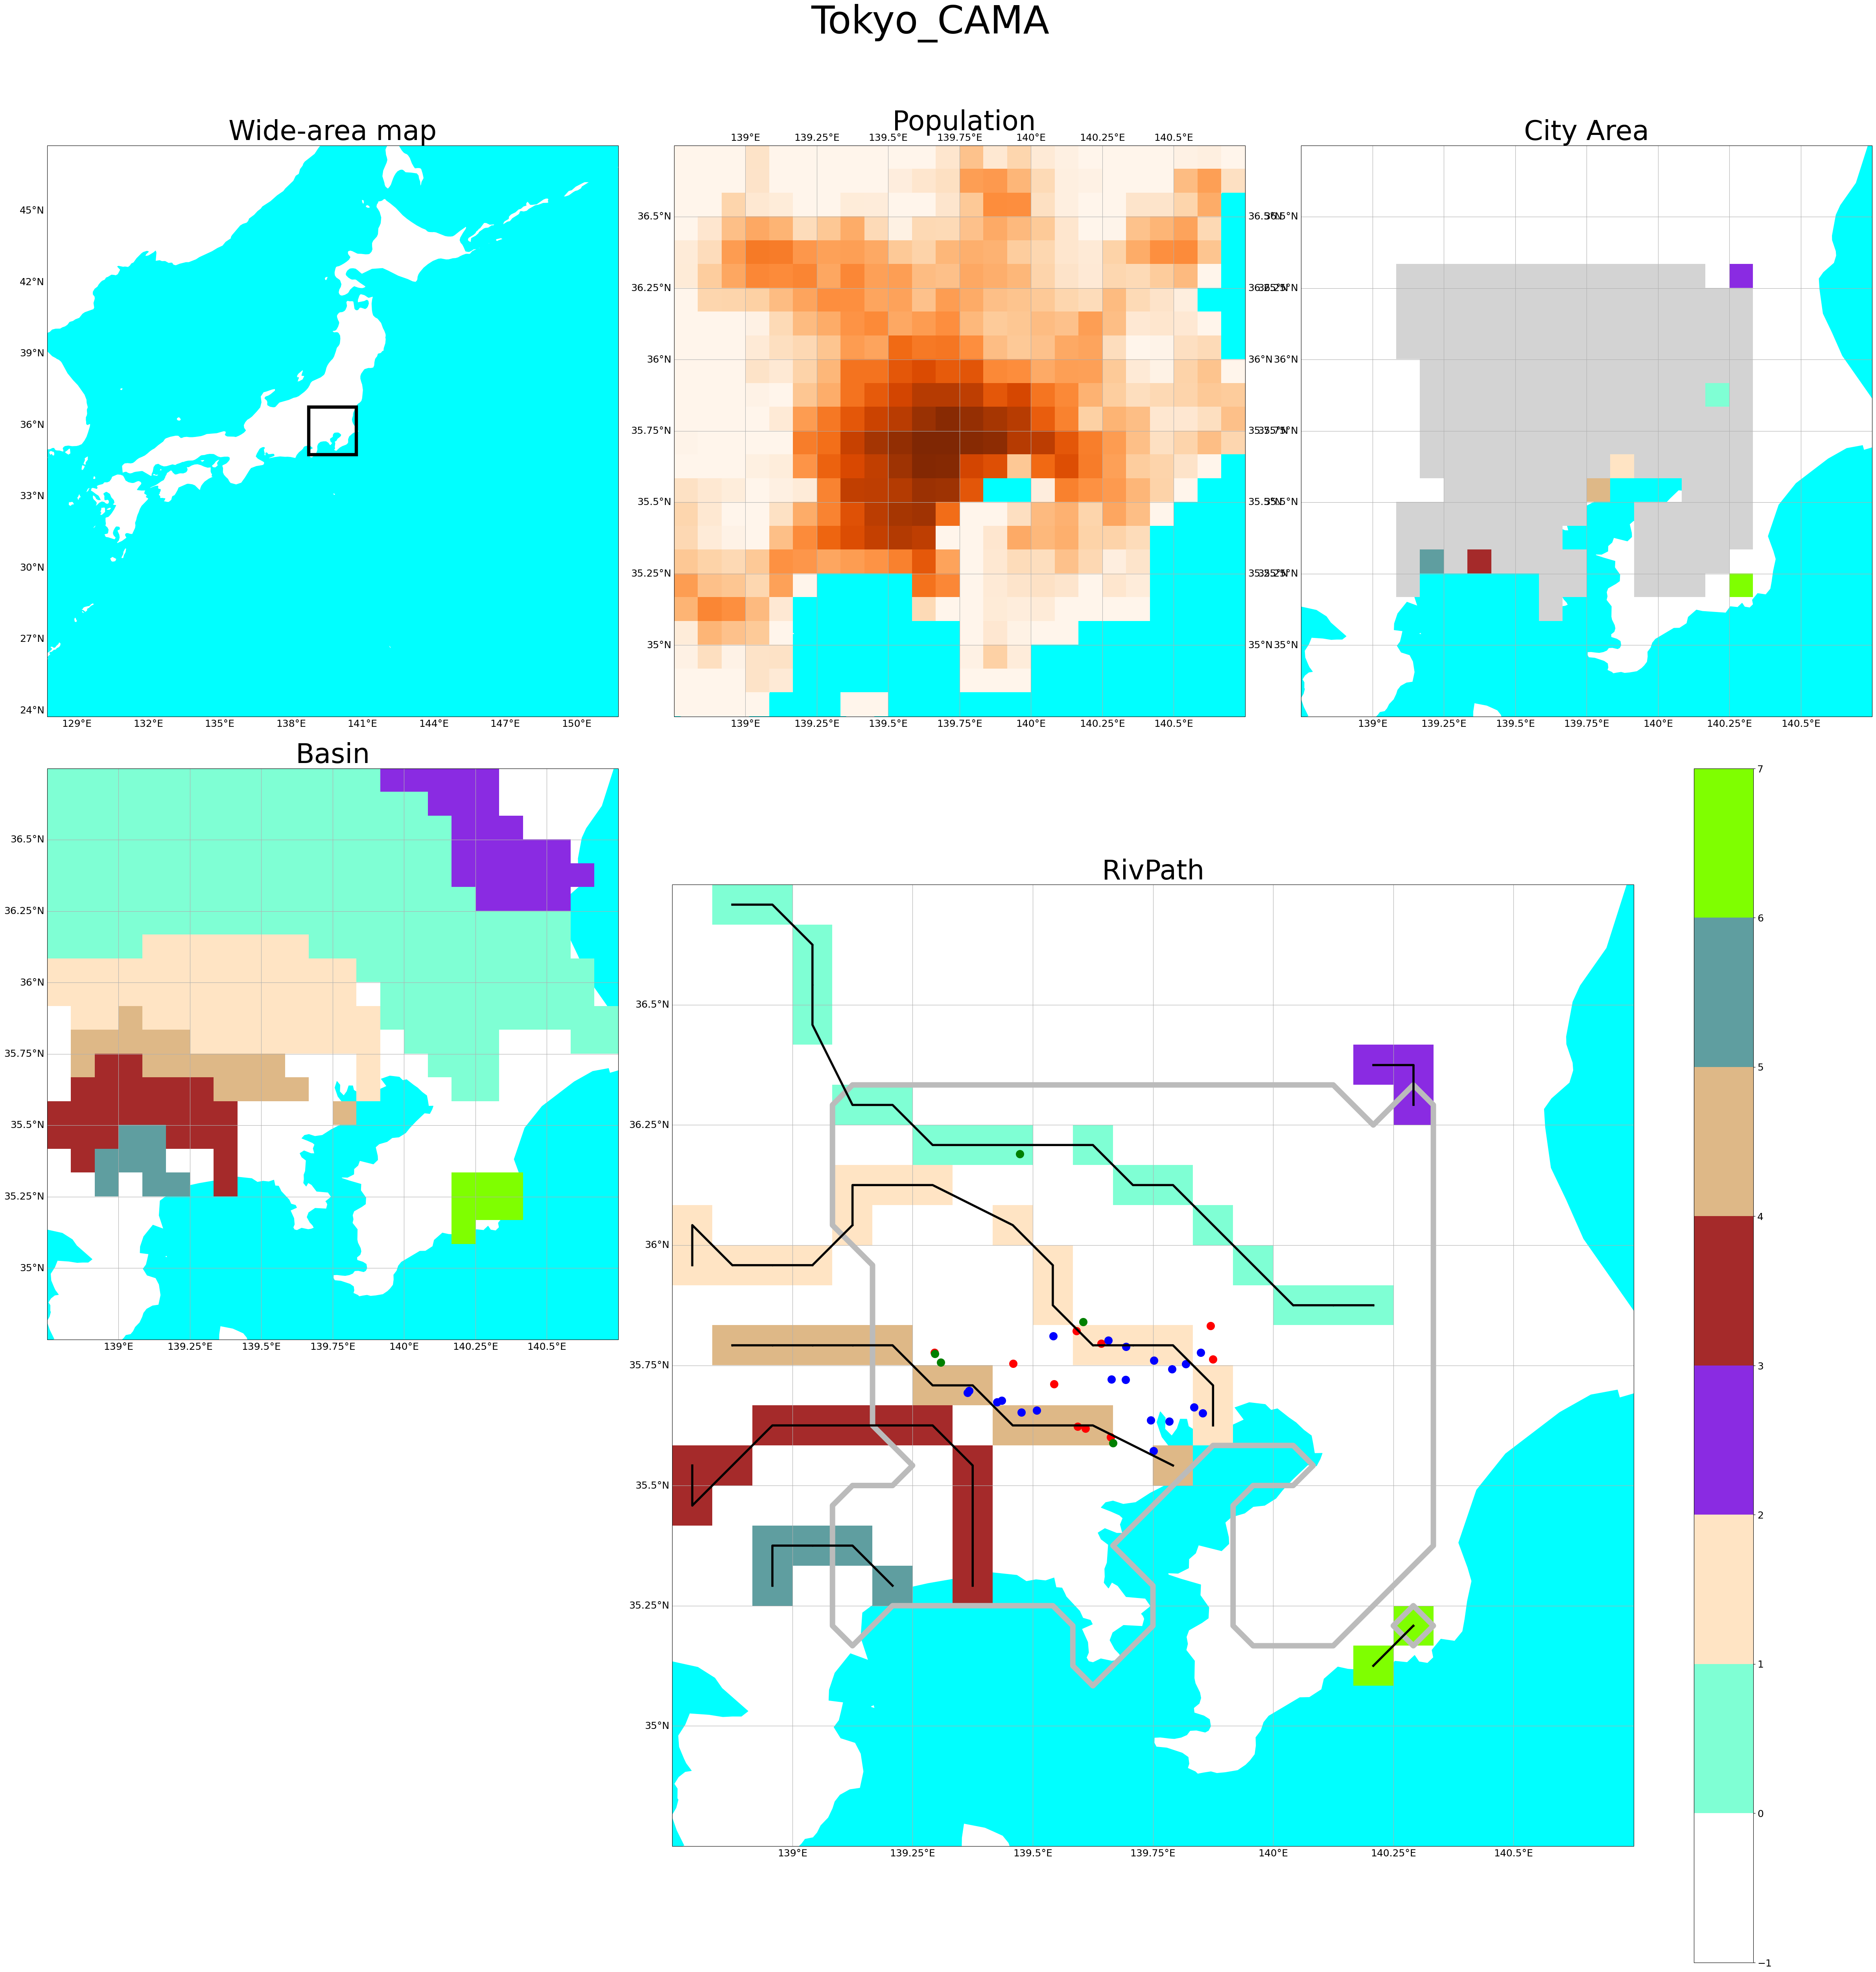

In [219]:
#---------------------------------------------------------------------------------------------------------------
# PATH
#---------------------------------------------------------------------------------------------------------------
root_dir = "/home/kajiyama/H08/H08_20230612"
# lonlat data
file_path = f"{root_dir}/map/dat/cty_lst_/city_list03.txt"
# city mask data
cmsk_path = f"{root_dir}/map/dat/cty_msk_"
elv_path = f"{root_dir}/map/dat/elevtn__/elevtn.CAMA.gl5"
pop_path = f"{root_dir}/map/dat/pop_tot_/C05_a___20000000.gl5" # @kajiyama
# riv data
rivnum_path = f"{root_dir}/map/out/riv_num_/rivnum.CAMA.gl5"
rivara_path = f"{root_dir}/map/out/riv_ara_/rivara.CAMA.gl5"
rivnxl_path = f"{root_dir}/map/out/riv_nxl_/rivnxl.CAMA.gl5"
# takahashi data
josui_path = f"{root_dir}/map/dat/josui_gesui_seki/20230725_jyousui.csv"
gesui_path = f"{root_dir}/map/dat/josui_gesui_seki/20230725_gesui.csv"
seki_path = f"{root_dir}/map/dat/josui_gesui_seki/20230725_seki.csv"

#---------------------------------------------------------------------------------------------------------------
# Initialization
#---------------------------------------------------------------------------------------------------------------
main_city_list_4 = ["London", "Tokyo", "Paris", "LosAngeles-LongBeach-SantaAna"]
remove_grid = 7
pop_vmin = 1e4
pop_vmax = 1e6
loop_num = 1 # number of the city
width = 1
a = 2160
b = 4320

#---------------------------------------------------------------------------------------------------------------
# Input Data
#---------------------------------------------------------------------------------------------------------------
# load takahashi data
josui = pd.read_csv(josui_path)
gesui = pd.read_csv(gesui_path)
seki = pd.read_csv(seki_path)

# city_list.txtを開いてデータを読み取る
with open(file_path, "r") as input_file:
    lines = input_file.readlines() 

# 新しいデータをcityrange_list.txtに書き込む
city_path = f"{root_dir}/map/dat/cty_lst_/cityrange_list_temp.txt"
with open(city_path, "w") as output_file:
    for line in lines:
        parts = line.split()  # 各行をスペースで分割
        col3 = float(parts[2])
        col4 = float(parts[3])
        # widthを使用して新しいデータを計算
        new_col1 = col3 - width
        new_col2 = col3 + width
        new_col3 = col4 - width
        new_col4 = col4 + width
        sotowaku_col1 = col3 - (12 * width)
        sotowaku_col2 = col3 + (12 * width)
        sotowaku_col3 = col4 - (12 * width)
        sotowaku_col4 = col4 + (12 * width)
        # 新しいデータを行に追加
        new_line = f"{line.strip()} {new_col1} {new_col2} {new_col3} {new_col4} {sotowaku_col1} {sotowaku_col2} {sotowaku_col3} {sotowaku_col4}\n"
        output_file.write(new_line)

#---------------------------------------------------------------------------------------------------------------
# load city information 
#---------------------------------------------------------------------------------------------------------------

# open city information text
with open(city_path, 'r') as file:
    all_lines = file.readlines()
    
#---------------------------------------------------------------------------------------------------------------
# city loop start 
#---------------------------------------------------------------------------------------------------------------

# city loop
for idx, line in enumerate(all_lines[:loop_num]):  # loop_numまでの行のみを処理
    print(idx)
    line = line.strip()
    if not line:
        break
    parts = line.split()
    city_num = parts[0].zfill(3)
    city = parts[5].replace("\"", "").replace("?", "").replace("/", "")
    lonmin = float(parts[6])
    lonmax = float(parts[7])
    latmin = float(parts[8])
    latmax = float(parts[9])
    sotowaku_lonmin = float(parts[10])
    sotowaku_lonmax = float(parts[11])
    sotowaku_latmin = float(parts[12])
    sotowaku_latmax = float(parts[13])
    
#---------------------------------------------------------------------------------------------------------------
# Get Lon Lat 
#---------------------------------------------------------------------------------------------------------------

    ### Define the latitudes and longitudes
    # West from UK is negative 0 <= lon <= -180
    # East from UK is positive 0 <= lon <= 180
    # small value to larger value (34-36, 138-140)
    lat = np.linspace(-90, 90, a+1)
    lon = np.linspace(-180, 180, b+1)

    ### Calculate the indices corresponding to the desired latitudes and longitudes
    lat_start, lat_end = np.searchsorted(lat, [latmin, latmax])
    lon_start, lon_end = np.searchsorted(lon, [lonmin, lonmax])
    sotowaku_lat_start, sotowaku_lat_end = np.searchsorted(lat, [sotowaku_latmin, sotowaku_latmax])
    sotowaku_lon_start, sotowaku_lon_end = np.searchsorted(lon, [sotowaku_lonmin, sotowaku_lonmax])
    
    # adjust to 0.25 grid (lonlat)
    if lat_start%3 == 0:
        lat_start = lat_start
    elif lat_start%3 == 1:
        lat_start -= 1
    elif lat_start%3 == 2:
        lat_start += 1
    # lon
    if lon_start%3 == 0:
        lon_start = lon_start
    elif lon_start%3 == 1:
        lon_start -= 1
    elif lon_start%3 == 2:
        lon_start += 1
        
    # 24 grid x 24 grid
    width_grid = width * 12 * 2
    lat_end = lat_start + width_grid
    lon_end = lon_start + width_grid
    
    # adjust to 0.25 grid (sotowaku)
    if sotowaku_lat_start%3 == 0:
        sotowaku_lat_start = sotowaku_lat_start
    elif sotowaku_lat_start%3 == 1:
        sotowaku_lat_start -= 1
    elif sotowaku_lat_start%3 == 2:
        sotowaku_lat_start += 1
    # lon
    if sotowaku_lon_start%3 == 0:
        sotowaku_lon_start = sotowaku_lon_start
    elif sotowaku_lon_start%3 == 1:
        sotowaku_lon_start -= 1
    elif sotowaku_lon_start%3 == 2:
        sotowaku_lon_start += 1

    # 12*24 grid x 12*24 grid
    sotowaku_width_grid = width * 12 * 24
    sotowaku_lat_end = sotowaku_lat_start + sotowaku_width_grid
    sotowaku_lon_end = sotowaku_lon_start + sotowaku_width_grid

    print(city)
    print("wide_lat", sotowaku_lat_start)
    print("wide_lat",sotowaku_lat_end)
    print("wide_lon",sotowaku_lon_start)
    print("wide_lon",sotowaku_lon_end, "\n")

    print("lat", lat_start)
    print("lat",lat_end)
    print("lon",lon_start)
    print("lon",lon_end, "\n")

#---------------------------------------------------------------------------------------------------------------
#  Load city mask
#---------------------------------------------------------------------------------------------------------------

    g_mask = np.fromfile(f'{cmsk_path}/city_00000{city_num}.gl5', 'float32').reshape(a, b)
    g_mask = np.flipud(g_mask)
    g_mask = np.ma.masked_where(g_mask >= 1E20, g_mask)
    g_mask_cropped = g_mask[lat_start:lat_end, lon_start:lon_end]
    g_mask_cropped = np.flipud(g_mask_cropped)
    
#---------------------------------------------------------------------------------------------------------------
#  Load population
#---------------------------------------------------------------------------------------------------------------

    g_pop = np.fromfile(pop_path, 'float32').reshape(a, b)
    g_pop = np.flipud(g_pop)
    g_pop = np.ma.masked_where(g_pop >= 1E20, g_pop)
    g_pop_cropped = g_pop[lat_start:lat_end, lon_start:lon_end]
    g_pop_cropped = np.flipud(g_pop_cropped)

#---------------------------------------------------------------------------------------------------------------
#  Load basin data
#---------------------------------------------------------------------------------------------------------------

    g_rivnum = np.fromfile(rivnum_path, 'float32').reshape(a, b)
    g_rivnum = np.flipud(g_rivnum)
    g_rivnum = np.ma.masked_where(g_rivnum >= 1E20, g_rivnum)
    Rivnum_A_array = g_rivnum[lat_start:lat_end, lon_start:lon_end]
    Rivnum_A_array = np.flipud(Rivnum_A_array)
    Rivnum_A_array = np.ma.masked_where(~np.isfinite(Rivnum_A_array) | (Rivnum_A_array == 0), Rivnum_A_array)

#---------------------------------------------------------------------------------------------------------------
#  Load upper river catchment area
#---------------------------------------------------------------------------------------------------------------

    g_rivara = np.fromfile(rivara_path, 'float32').reshape(a, b)
    g_rivara = np.flipud(g_rivara)
    g_rivara = np.ma.masked_where(g_rivara >= 1E20, g_rivara)
    g_rivara_cropped = g_rivara[lat_start:lat_end, lon_start:lon_end]
    g_rivara_cropped = np.flipud(g_rivara_cropped)
    g_rivara_cropped = np.ma.masked_where(~np.isfinite(g_rivara_cropped) | (g_rivara_cropped == 0), g_rivara_cropped)

#---------------------------------------------------------------------------------------------------------------
#  Load river's next l coordinate data
#---------------------------------------------------------------------------------------------------------------

    g_rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(a, b)
    g_rivnxl = np.flipud(g_rivnxl)
    g_rivnxl = np.ma.masked_where(g_rivnxl >= 1E20, g_rivnxl)
    g_rivnxl_cropped = g_rivnxl[lat_start:lat_end, lon_start:lon_end]
    g_rivnxl_cropped = np.flipud(g_rivnxl_cropped)
    g_rivnxl_cropped = np.ma.masked_where(~np.isfinite(g_rivnxl_cropped) | (g_rivnxl_cropped == 0), g_rivnxl_cropped)
    
#---------------------------------------------------------------------------------------------------------------
#   rivnum data only where city mask exists
#---------------------------------------------------------------------------------------------------------------

    Rivnum_A_array_city = np.where(g_mask_cropped == 1, Rivnum_A_array, np.nan)
    Rivnum_A_array_city = np.ma.masked_where(~np.isfinite(Rivnum_A_array_city) | (Rivnum_A_array_city == 0), Rivnum_A_array_city)
    
#---------------------------------------------------------------------------------------------------------------
#  　主要な流域を選ぶ(Rivnum_B_array)
#---------------------------------------------------------------------------------------------------------------

    # g_ara_num_croppedを構造化配列として作成
    dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
    g_ara_num_cropped = np.empty(g_rivara_cropped.shape, dtype=dtype)
    
    # rivaraとrivnumのデータをg_ara_num_croppedに追加
    g_ara_num_cropped['rivara'] = g_rivara_cropped
    g_ara_num_cropped['rivnum'] = Rivnum_A_array
    
    # g_ara_num_croppedのrivnumをマスク付き配列として取得
    Rivnum_A_array_masked = np.ma.masked_array(g_ara_num_cropped['rivnum'], np.isnan(g_ara_num_cropped['rivnum']))
    
    # マスクされていない要素(Nanじゃない値)のユニークな値とその出現回数を取得
    unique_values, counts = np.unique(Rivnum_A_array_masked.compressed(), return_counts=True)
    value_counts_dict = dict(zip(unique_values, counts))
    
    # 値（個数）の多い順にソート
    # 都市マスク内の流域番号で，出現回数が多い順に並んでいるはず
    sorted_dict_by_value_descending = dict(sorted(value_counts_dict.items(), key=lambda item: item[1], reverse=True))
    
    # 値（個数）がremove grid以上の項目のみを持つ新しい辞書を作成
    # 流域が小さい物は削除する作業に該当
    filtered_dict_g12 = {key: value for key, value in sorted_dict_by_value_descending.items() if value >= remove_grid}
    
    # 空っぽのマスク配列(24x24を作る)
    Rivnum_B_array = np.ma.masked_all(Rivnum_A_array_masked.shape, dtype='float32')
    
    # filtered_dict_g12のキー(流域ID)に対して繰り返し処理を行い、
    # それぞれのrivnumがRivnum_A_array_maskedに存在する位置を特定します。
    for rivnum_id in filtered_dict_g12.keys():
        # 同じrivnumの位置を取得
        matching_positions = np.where(Rivnum_A_array_masked.data == rivnum_id)
        # これらの位置に新しい配列にrivnumを設定
        Rivnum_B_array[matching_positions] = rivnum_id
        
    # 0 or 非有限数の要素をマスクする
    # Rivnum_B_arrayは都市マスクなしのすべての流域
    Rivnum_B_array = np.ma.masked_where(~np.isfinite(Rivnum_B_array) | (Rivnum_B_array == 0), Rivnum_B_array)
    
#---------------------------------------------------------------------------------------------------------------
#  Rivnum_B_array only where city mask exist
#---------------------------------------------------------------------------------------------------------------

    # Rivnum_B_arrayの値が存在しないか、値が0の場所をTrueとするマスクを作成
    invalid_mask = np.isnan(Rivnum_B_array) | (Rivnum_B_array == 0)
    # g_mask_croppedが1でない場所、または上記のマスクがTrueの場所をマスクとして指定
    cityarea_with_rivnum_b_array = np.ma.masked_where((g_mask_cropped != 1) | invalid_mask, Rivnum_B_array)
    
    # Rivnum_B_arrayで都市マスク内以外の値をnp.nanに変更
    Rivnum_B_array_citymasked = np.where(g_mask_cropped == 1, Rivnum_B_array, np.nan)
    # 欠損値 or 非有限数の要素をマスクする
    Rivnum_B_array_citymasked = np.ma.masked_where(~np.isfinite(Rivnum_B_array_citymasked) | (Rivnum_B_array_citymasked >= 1E20), Rivnum_B_array_citymasked)
    
    #二つの処理はほぼ同じであり，rivnum_B_array_citymaskedは都市マスクの外にnan値を持つ

#---------------------------------------------------------------------------------------------------------------
#  rivaraを使って河口グリッドを探索する
#---------------------------------------------------------------------------------------------------------------

    # g_ara_num_croppedを構造化配列として作成
    dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
    g_ara_num_cropped = np.empty(g_rivara_cropped.shape, dtype=dtype)
    
    # rivaraとrivnumのデータをg_ara_num_croppedに追加
    g_ara_num_cropped['rivara'] = g_rivara_cropped
    g_ara_num_cropped['rivnum'] = Rivnum_B_array_citymasked
    
    # マスクされていない要素のユニークな値とその出現回数を取得
    # 都市マスク内の流域グリッド数で出現回数が多い物を探索している
    unique_values, counts = np.unique(cityarea_with_rivnum_b_array.compressed(), return_counts=True)
    value_counts_dict = dict(zip(unique_values, counts))
    
    # データ型とサイズに基づいて新しい配列を作成
    rivnum_max_array = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')
    
    for rivnum_id in value_counts_dict.keys():
        # 同じrivnumの位置を取得
        matching_positions = np.where(g_ara_num_cropped['rivnum'] == rivnum_id) 
        # これらの位置におけるrivaraの最大値の位置を取得
        max_rivara_position = np.argmax(g_ara_num_cropped['rivara'][matching_positions])       
        # 最大のrivaraの位置に対応するrivnumを新しい配列に保存する
        # 河口グリッドに該当
        rivnum_max_array[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id
        
#---------------------------------------------------------------------------------------------------------------
#  make riv nextl lonlat coordinate array 24x24x2
#---------------------------------------------------------------------------------------------------------------
    
    # l coordiate to lonlat coordinate
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    result = np.empty(g_rivnxl_cropped.shape, dtype=tuple)
    mask = ~np.isnan(g_rivnxl_cropped)
    result[mask] = vfunc(g_rivnxl_cropped[mask])
    result_shape = (result.shape[0], result.shape[1], 2)

    result_list = []
    for row in result:
        for x, y in row:
            # width_grid = cropped scale(24x24)
            modified_x = width_grid - (x - lat_start)
            modified_y = y - lon_start
            result_list.append((modified_x, modified_y))

    result_2424 = np.array(result_list).reshape(result_shape)
    result_2424 = result_2424.astype(int)
        
#---------------------------------------------------------------------------------------------------------------
#  河口からの
#  その中で流域面積が最大になるグリッドを探索
#---------------------------------------------------------------------------------------------------------------

    results_dict = {}
    # マスク内に存在する流域ID
    unique_ids = np.unique(rivnum_max_array.compressed())
    #riv_path_array = rivnum_max_array.copy()
    riv_path_array = np.ma.masked_all(rivnum_max_array.shape, dtype='float32')
    visited_coords = set()

    for uid in unique_ids:
        # 河口グリッドのインデックス
        coords_a = np.argwhere(rivnum_max_array == uid)
        riv_path_array[coords_a[0][0], coords_a[0][1]] = uid
        if coords_a.size > 0:
            target_coord = tuple(coords_a[0]) 
            path_coords = [target_coord]
            for _ in range(300):
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                # result_2424はrivnxlのlonlat表示なので，target_coordを次のセルに指し示すrivnxlのインデックスを取得
                matched_coords = np.argwhere(np.all(target_coord == result_2424, axis=2))
                if len(matched_coords) == 0:
                    break
                # マッチしたインデックスの中でrivaraが最大のものを選ぶ
                unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                if not unvisited_matched:
                    break
                # g_rivara_croppedに座標をいれて，最大最小を比べている
                rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
                max_index = np.argmax(rivara_values)
                best_coord = unvisited_matched[max_index]
                # 河口グリッドのファイルに経路をそれぞれ足していく
                riv_path_array[best_coord[0], best_coord[1]] = uid
                target_coord = best_coord 
                # path_coordに経路を足していく
                path_coords.append(target_coord)

            # 各流域の経路を保存
            results_dict[uid] = path_coords
            
#---------------------------------------------------------------------------------------------------------------
# 都市マスク内に存在する流域(unique_id)を全範囲(Rivnum_B_array)で取得する
#---------------------------------------------------------------------------------------------------------------

    Rivnum_masked_array = np.ma.masked_all(Rivnum_A_array_masked.shape, dtype='float32')
    for uid in unique_ids:
        row_indices, col_indices = np.where(Rivnum_B_array == uid)
        Rivnum_masked_array[row_indices, col_indices] = uid

#---------------------------------------------------------------------------------------------------------------
# DRAW
#---------------------------------------------------------------------------------------------------------------

    # Create the plot
    fig = plt.figure(figsize=(60, 60))
    fig.suptitle(f'{city}_CAMA', fontsize=70, y=0.94)

    gs = gridspec.GridSpec(6, 6)

    # font size
    plt.rcParams['font.size'] = 18

    # convert real lonlat to h08 lonlat
    latmin_gl5 = lat[lat_start]
    latmax_gl5 = lat[lat_end]
    lonmin_gl5 = lon[lon_start]
    lonmax_gl5 = lon[lon_end]

    sotowaku_latmin_gl5 = lat[sotowaku_lat_start]
    sotowaku_latmax_gl5 = lat[sotowaku_lat_end]
    sotowaku_lonmin_gl5 = lon[sotowaku_lon_start]
    sotowaku_lonmax_gl5 = lon[sotowaku_lon_end]

    # projection
    projection = ccrs.PlateCarree()
    extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)
    extent2 = (sotowaku_lonmin_gl5, sotowaku_lonmax_gl5, sotowaku_latmin_gl5, sotowaku_latmax_gl5)
    
#---------------------------------------------------------------------------------------------------------------
# DRAW Wide-area map
#---------------------------------------------------------------------------------------------------------------

    rectangle_lon_min, rectangle_lon_max, rectangle_lat_min, rectangle_lat_max = extent

    rectangle = Rectangle((rectangle_lon_min, rectangle_lat_min),
                        rectangle_lon_max - rectangle_lon_min,
                        rectangle_lat_max - rectangle_lat_min,
                        facecolor='none',
                        edgecolor='black',
                        linewidth=6,
                        transform=ccrs.PlateCarree(), zorder=2)
    
    # add subplot(gs=6x6, ax9=2x2)
    ax9 = fig.add_subplot(gs[0:2, 0:2], projection=projection)
    ax9.set_extent(extent2, crs=projection)
    gl = ax9.gridlines(draw_labels=True)
    gl.xlines = False 
    gl.ylines = False
    gl.top_labels = False   
    gl.right_labels = False 
    
    # Add features and labels   
    ax9.add_feature(cfea.OCEAN, color='#00FFFF')
    ax9.add_patch(rectangle)
    ax9.set_title('Wide-area map', fontsize=50)
    
#---------------------------------------------------------------------------------------------------------------
#  Basinの図を作図する
#---------------------------------------------------------------------------------------------------------------

    def plot_data(fig, gs_position, data, title, Rivnum_masked_array):
        # cmap
        num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
        indexed_data = np.vectorize(get_index)(data, index_dict)
        
        # draw
        ax = fig.add_subplot(gs_position, projection=projection)
        ax.set_extent(extent, projection)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False   # Turn off top x-axis labels
        gl.right_labels = False # Turn off right y-axis labels
        ax.add_feature(cfea.OCEAN, color='#00FFFF')
        img = ax.imshow(indexed_data,
                        origin='upper',
                        extent=extent,
                        transform=projection,
                        cmap=cmap,
                        vmin=-1, vmax=num_colors)
        ax.set_title(title, fontsize=50)
        return ax, img

    ax18, img18 = plot_data(fig, gs[2:4, 0:2], Rivnum_masked_array, 'Basin', Rivnum_masked_array)

#---------------------------------------------------------------------------------------------------------------
#  City_areaを作図
#---------------------------------------------------------------------------------------------------------------

    cmap_gray = colors.ListedColormap(['none', 'lightgray'])
    bounds_gray = [0, 0.5, 1]
    norm_gray = colors.BoundaryNorm(bounds_gray, cmap_gray.N)
    
    def plot_data_mask(fig, gs_position, data, title, Rivnum_masked_array):
        # cmap
        num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
        indexed_data = np.vectorize(get_index)(data, index_dict)
        
        # draw
        ax = fig.add_subplot(gs_position, projection=projection)
        ax.set_extent(extent, projection)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False   # Turn off top x-axis labels
        gl.right_labels = False # Turn off right y-axis labels
        ax.add_feature(cfea.OCEAN, color='#00FFFF')
        img = ax.imshow(indexed_data,
                        origin='upper',
                        extent=extent,
                        transform=projection,
                        cmap=cmap,
                        vmin=-1, vmax=num_colors, zorder=2)
        img_gray = ax.imshow(g_mask_cropped, origin='upper', extent=extent, transform=projection, cmap=cmap_gray, norm=norm_gray, zorder=1)
        ax.set_title(title, fontsize=50)
        return ax, img

    ax3, img12 = plot_data_mask(fig, gs[0:2, 4:6], rivnum_max_array, 'City Area', Rivnum_masked_array)
    
#---------------------------------------------------------------------------------------------------------------
# 人口をプロットする
#---------------------------------------------------------------------------------------------------------------

    # Add subplot for population data
    ax = fig.add_subplot(gs[0:2, 2:4], projection=projection)
    # Set extent
    ax.set_extent(extent, crs=projection)
    # set gridline
    ax.gridlines(draw_labels=True)
    # Add features and labels
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    # Plot the population data
    img = ax.imshow(g_pop_cropped,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap='Oranges',
                    norm=colors.LogNorm(vmin=pop_vmin, vmax=pop_vmax)) # Use log color scale
    # set colorbar
    #fig.colorbar(img, ax=ax, orientation='horizontal')
    # Set title
    ax.set_title(' Population', fontsize=50)
    
#---------------------------------------------------------------------------------------------------------------
# RivPathの図を描く
#---------------------------------------------------------------------------------------------------------------

    def plot_path_zorder(fig, gs_position, data, title, Rivnum_masked_array, results_dict=None, latmin_gl5=None, latmax_gl5=None, lonmin_gl5=None, lonmax_gl5=None):
        # cmap
        num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
        indexed_data = np.vectorize(get_index)(data, index_dict)
        
        # draw
        ax = fig.add_subplot(gs_position, projection=projection)
        ax.set_extent(extent, projection)
        ax.scatter(josui['lon'], josui['lat'], color='red', s=200, transform=projection,zorder=3)
        ax.scatter(gesui['lon'], gesui['lat'], color='blue', s=200, transform=projection, zorder=3)
        ax.scatter(seki['lon'], seki['lat'], color='green', s=200, transform=projection, zorder=3)
        light_gray = '#BBBBBB'  # 16進数で薄いグレー
        
        # city maskをコンターで描く
        contour = ax.contour(g_mask_cropped, levels=[0.5], colors=light_gray, linewidths=10, origin='upper', extent=extent, transform=projection, zorder=3)

        # labels
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False   # Turn off top x-axis labels
        gl.right_labels = False # Turn off right y-axis labels

        # ocean
        ax.add_feature(cfea.OCEAN, color='#00FFFF')
        ax.add_feature(cfea.LAKES, color='#00FFFF')
        
        # rivpath
        img = ax.imshow(indexed_data,
                        origin='upper',
                        extent=extent,
                        transform=projection,
                        cmap=cmap,
                        vmin=-1, vmax=num_colors, zorder=2)
        light_gray = '#BBBBBB'  # 16進数で薄いグレー
        ax.set_title(title, fontsize=50)

        # path to paths
        if results_dict is not None and latmin_gl5 is not None and latmax_gl5 is not None and lonmin_gl5 is not None and lonmax_gl5 is not None:
            for key, path in results_dict.items():
                lat_coords, lon_coords = zip(*path)
                lat_coords = [latmax_gl5 - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
                lon_coords = [(lon + (1/(width * 2)))*(1/12) + lonmin_gl5 for lon in lon_coords]
                ax.plot(lon_coords, lat_coords, marker='o', markersize=2, color='black', linestyle='-', linewidth=4, transform=projection, zorder=5)
        
        # colorbar
        fig.colorbar(img, ax=ax)

        return ax, img

    ax22, img22 = plot_path_zorder(fig, gs[2:6, 2:6], riv_path_array, 'RivPath', Rivnum_masked_array, results_dict=results_dict, latmin_gl5=latmin_gl5, latmax_gl5=latmax_gl5, lonmin_gl5=lonmin_gl5, lonmax_gl5=lonmax_gl5)

    plt.show()
    

# 必要なデータファイル
### 形式がlonlatかl座標化を明記する必要がある
### riv_num_max_array = 下水処理場
### g_mask_cropped = 都市マスク
### riv_path_array = 流域IDが含まれている経路ファイル
### results_dict = 流域IDがkeyになっている経路座標の辞書 coord[0]とcoord[1]で格納されている
### g_rivara_cropped = 流域面積のファイル

[[-1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2  2 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  0  0  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1  1  1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  0  0  0 -1 -1 -1 -1 -1 -1]
 [-1  4  4  4  4  4 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  4  4 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  3  3  3  3  3 -1

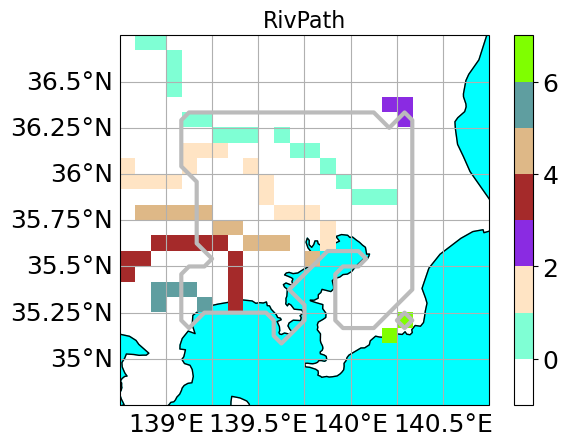

In [220]:
def path_zorder(data, title, Rivnum_masked_array, latmin_gl5=None, latmax_gl5=None, lonmin_gl5=None, lonmax_gl5=None):
    data = np.where(data<1e19, data, -1)
    num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
    indexed_data = np.vectorize(get_index)(data, index_dict)
    print(indexed_data)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    ax.set_extent(extent, projection)
    light_gray = '#BBBBBB'  # 16進数で薄いグレー
    # city maskをコンターで描く
    contour = ax.contour(g_mask_cropped, levels=[0.5], colors=light_gray, linewidths=3, origin='upper', extent=extent, transform=projection, zorder=10)


    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False   # Turn off top x-axis labels
    gl.right_labels = False # Turn off right y-axis labels

    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    ax.add_feature(cfea.LAKES, color='#00FFFF')
    
    img = ax.imshow(indexed_data,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap=cmap,
                    vmin=-1, vmax=num_colors, zorder=2)
    ax.set_title(title, fontsize=16)
    fig.colorbar(img, ax=ax)
    
path_zorder(riv_path_array, 'RivPath', Rivnum_masked_array, latmin_gl5=latmin_gl5, latmax_gl5=latmax_gl5, lonmin_gl5=lonmin_gl5, lonmax_gl5=lonmax_gl5)

# 浄水場位置
### 浄水場 = 経路ファイルから流域面積最小を選ぶ
### 都市マスク外までpathが伸びているので都市マスク内にpathをとどめなくてはいけない

[848.0, 2718.0, 2972.0, 4850.0, 6065.0, 9986.0, 14819.0]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  0  0  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1  1  1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  0  0  0 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  4 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  4  4 -1 -1 -1 -1 -1  1

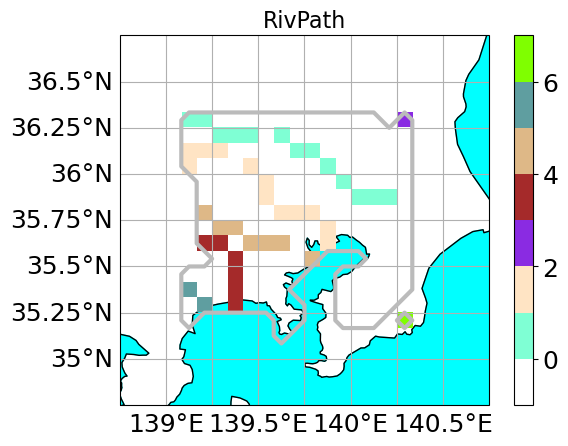

In [221]:
# determine josui place

josui_lst = []

# get uid
tmp_id_lst = list(results_dict.keys())
print(tmp_id_lst)

# city mask
tmp_uid_masked = np.where(g_mask_cropped==1, riv_path_array, np.nan)
path_zorder(tmp_uid_masked, 'RivPath', Rivnum_masked_array, latmin_gl5=latmin_gl5, latmax_gl5=latmax_gl5, lonmin_gl5=lonmin_gl5, lonmax_gl5=lonmax_gl5)

# loop uid
for key_num in tmp_id_lst:
    # get river path
    indices = np.argwhere(tmp_uid_masked == key_num)
    print(f"len(paths) {len(indices)}")
    
    # get minmum river area
    rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in indices]
    tmp_arg = np.argmin(rivara_values)
    josui = indices[tmp_arg]
    
    # add to list
    josui_lst.append(josui)
    
print(f"josui_lst {josui_lst}")

#  各都市の浄水場情報をgl5の形式にして保存する

josu_array.shape (24, 24)
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

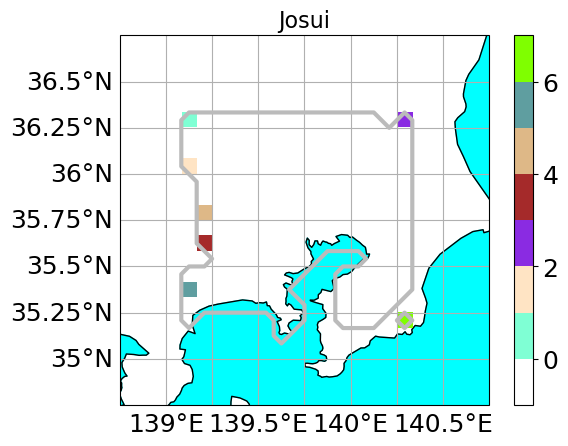

In [222]:
# 浄水場情報を24x24のマスクファイルに保存
josui_array = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')
print(f"josu_array.shape {josui_array.shape}")

for matching_position, uid in zip(josui_lst, tmp_id_lst):
    josui_array[matching_position[0], matching_position[1]] = uid
    
path_zorder(josui_array, 'Josui', Rivnum_masked_array, latmin_gl5=latmin_gl5, latmax_gl5=latmax_gl5, lonmin_gl5=lonmin_gl5, lonmax_gl5=lonmax_gl5)

print(f"\n josu_array \n {josui_array}")

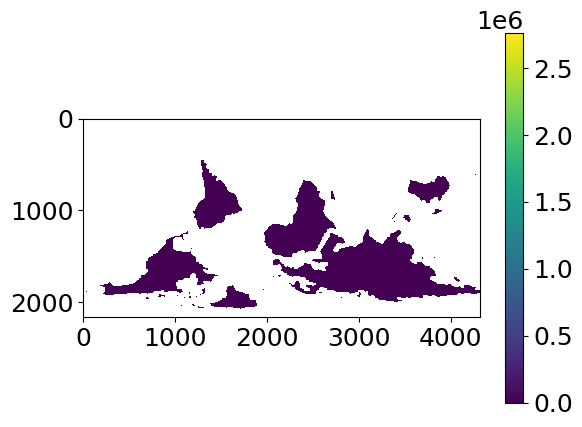

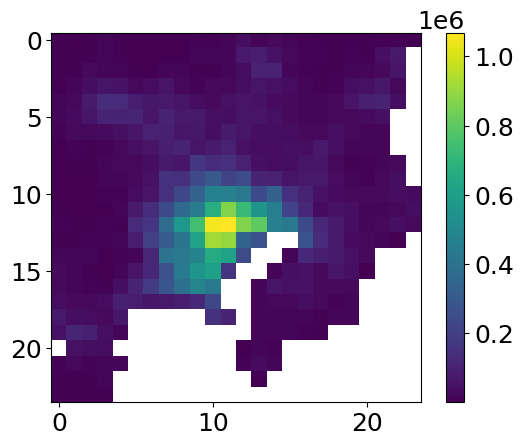

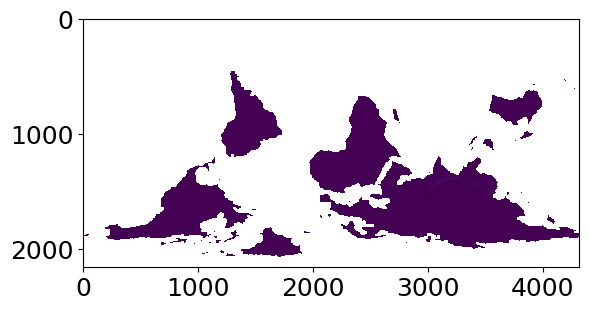

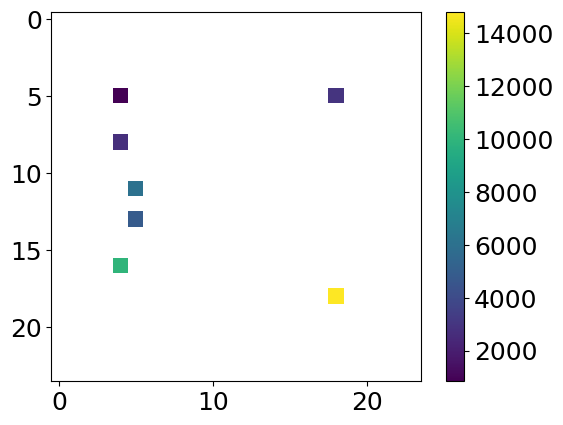

In [223]:
# どうやってひっくり返しているかチェック

# オリジナルはさかさまじゃないよ
g_elv = np.fromfile(elv_path, 'float32').reshape(a, b)
# ひっくり返してからじゃないとlatとlonの区間が合わない
g_elv = np.flipud(g_elv)
g_elv = np.ma.masked_where(g_elv >= 1E20, g_pop)
plt.imshow(g_elv)
plt.colorbar()
plt.show()

g_elv_cropped = g_elv[lat_start:lat_end, lon_start:lon_end]
# croppが終わったら再度ひっくり返す
g_elv_cropped = np.flipud(g_elv_cropped)
plt.imshow(g_elv_cropped)
plt.colorbar()
plt.show()

#　cropp区間の値を変換
josui_for_save = np.ma.masked_all(g_elv.shape, dtype='float32')
g_elv[lat_start:lat_end, lon_start:lon_end] = np.flipud(josui_array)
plt.imshow(g_elv)
plt.show()

# 再度クロップ
g_elv_cropped = g_elv[lat_start:lat_end, lon_start:lon_end]
# croppが終わったら再度ひっくり返す
g_elv_cropped = np.flipud(g_elv_cropped)
plt.imshow(g_elv_cropped)
plt.colorbar()
plt.show()

# 保存するときは世界地図をひっくり返して，正しい向きにしておく
g_elv = np.flipud(g_elv)
#np.save

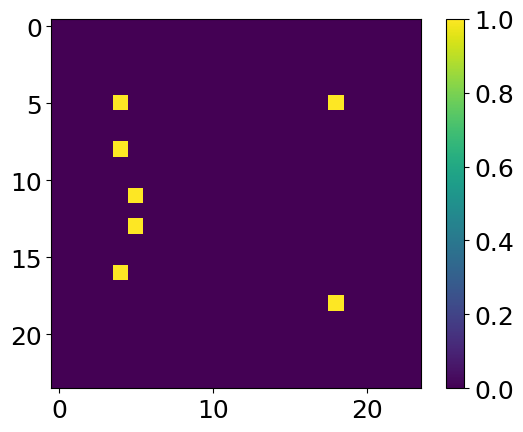

In [224]:
# croppするときは必ずひっくり返す
# 保存・描写するときにもとに戻す
### 実際に浄水場位置を保存する

# 保存用ファイル作成
josui_for_save = np.ma.masked_all(g_elv.shape, dtype='float32')

#　cropp区間の値を変換(世界地図はひっくり返っている)
josui_for_save[lat_start:lat_end, lon_start:lon_end] = np.flipud(josui_array)

# 浄水場を1, それ以外を0とするバイナリーファイルに変換
josui_for_save = np.ma.filled(josui_for_save, fill_value=0)
josui_for_save = np.where(josui_for_save > 0, 1, josui_for_save)

# cropが正しく変換されているか確認
josui_cropped = josui_for_save[lat_start:lat_end, lon_start:lon_end]
# croppが終わったらひっくり返す(世界地図上向き)
josui_cropped = np.flipud(josui_cropped)
plt.imshow(josui_cropped)
plt.colorbar()
plt.show()

# 保存するときは世界地図をひっくり返して，正しい向きにしておく
# city purification plant
num = idx+1 # city ID
save_path = f'/home/kajiyama/H08/H08_20230612/map/dat/cty_prf_/city_{num:08d}.gl5'
josui_for_save = np.flipud(josui_for_save)
#josui_for_save.astype(np.float32).tofile(save_path)
#print(f"{save_path} saved")

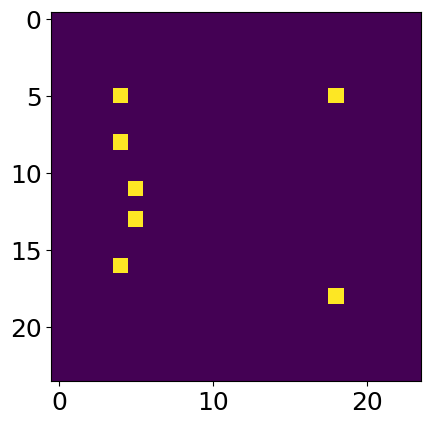

In [225]:
# load file
tmp = np.fromfile(save_path, 'float32').reshape(a, b)
tmp = np.flipud(tmp)
tmp_crop = tmp[lat_start:lat_end, lon_start:lon_end]
tmp_crop = np.flipud(tmp_crop)
plt.imshow(tmp_crop)

#  lonlatを一文一文読まなくても都市名で指定できるようにする

In [226]:
# 新しいデータをcityrange_list_temp.txtから読み込む
with open(city_path, 'r') as file:
    all_lines = file.readlines()
    
city_index = 12
line = all_lines[city_index-1]
line = line.strip()
parts = line.split()
city_num = parts[0].zfill(3)
city = parts[5].replace("\"", "").replace("?", "").replace("/", "")

print(city_num)
print(city)


012
LosAngeles-LongBeach-SantaAna
